## Solving Heat equation using PINN

In [1]:
import functools
import matplotlib.pyplot as plt
import torch
torch.device('cuda' if torch.cuda.is_available() else 'cpu')


device(type='cuda')

In [6]:
import numpy as np
# Comput the gradient 
def grad(outputs, inputs):
    """ Copute the partial derivatives of an output with the given inputs
    Args: 
        outputs: (N, 1) tensor
        inputs: (N, 1) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs= torch.ones_like(outputs),
                               create_graph= True)
    

def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T


    

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

Text(0.5, 0, 'Time (s)')

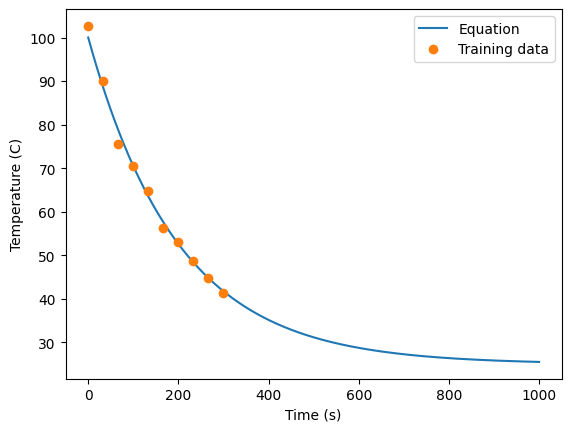

In [30]:
# Implement the Equation
np.random.seed(10)

Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')


## Normal Nueral Network

Epoch 0/20000, loss: 4802.96
Epoch 2000/20000, loss: 2485.41
Epoch 4000/20000, loss: 1932.28
Epoch 6000/20000, loss: 365.42
Epoch 8000/20000, loss: 14.20
Epoch 10000/20000, loss: 2.83
Epoch 12000/20000, loss: 2.48
Epoch 14000/20000, loss: 2.33
Epoch 16000/20000, loss: 2.33
Epoch 18000/20000, loss: 2.33


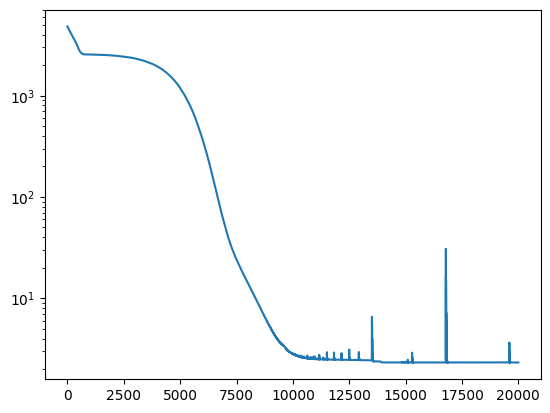

In [32]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(device=DEVICE)
# Convert temperature to tensor format


losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Epoch 0/20000, loss: 11708.38
Epoch 2000/20000, loss: 4095.32
Epoch 4000/20000, loss: 2549.17
Epoch 6000/20000, loss: 1691.20
Epoch 8000/20000, loss: 1268.08
Epoch 10000/20000, loss: 1064.02
Epoch 12000/20000, loss: 964.16
Epoch 14000/20000, loss: 897.02
Epoch 16000/20000, loss: 993.78
Epoch 18000/20000, loss: 761.40


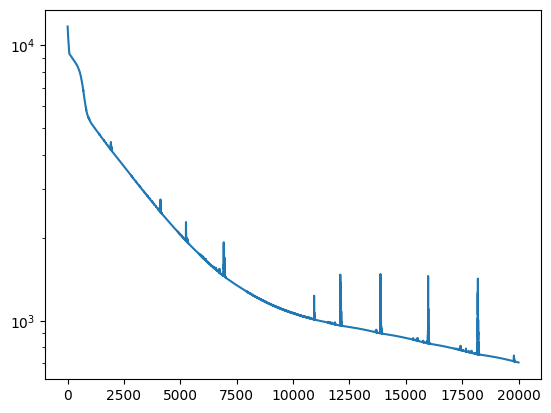

In [33]:
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

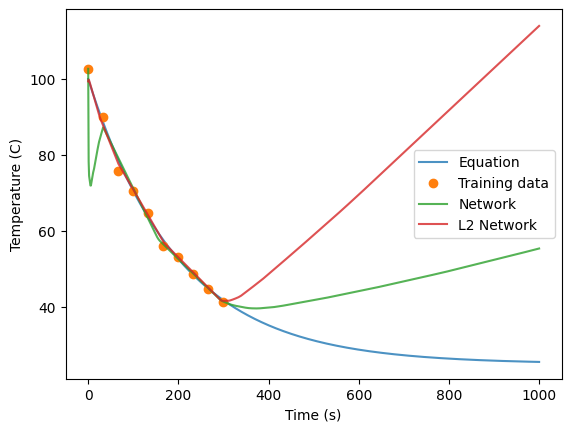

In [34]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

## PINN (Adding reg as Physics loss)

Epoch 0/30000, loss: 4588.71
Epoch 3000/30000, loss: 2463.60
Epoch 6000/30000, loss: 616.84
Epoch 9000/30000, loss: 4.24
Epoch 12000/30000, loss: 3.20
Epoch 15000/30000, loss: 1.91
Epoch 18000/30000, loss: 1.61
Epoch 21000/30000, loss: 1.39
Epoch 24000/30000, loss: 1.26
Epoch 27000/30000, loss: 1.19


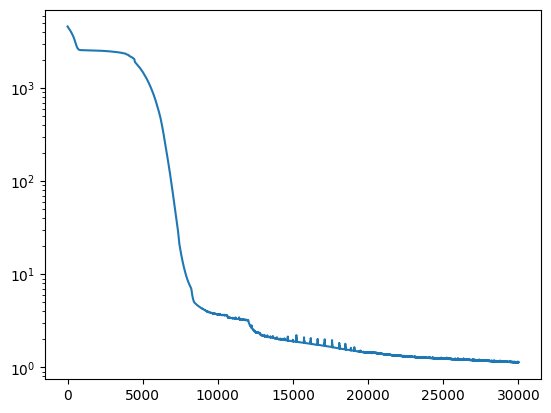

In [35]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps = 1000).view(-1, 1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R  *(Tenv-temps) - dT
    return torch.mean(pde**2)

net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

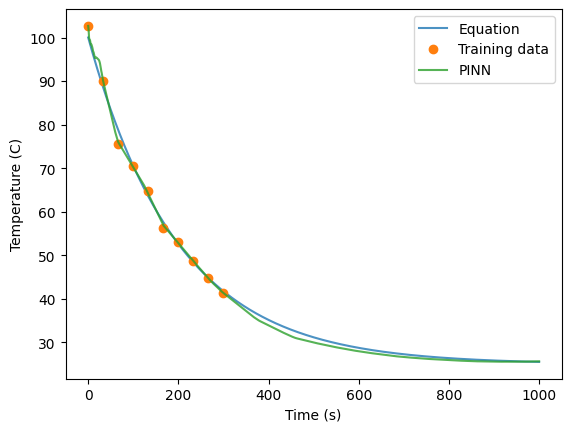

In [36]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')